In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
%matplotlib inline
import gc
import os
import copy
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

OSError: dlopen(/Users/shaaguns/opt/anaconda3/lib/python3.9/site-packages/lightgbm/lib/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <3AF1EF0C-311C-31EC-BCE3-679F37ABEE16> /Users/shaaguns/opt/anaconda3/lib/python3.9/site-packages/lightgbm/lib/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
# INPUT_DIR = '/kaggle/input/linking-writing-processes-to-writing-quality'
train_logs = pd.read_csv('train_logs.csv')
train_scores = pd.read_csv('train_scores.csv')
test_logs = pd.read_csv('test_logs.csv')
ss_df = pd.read_csv('sample_submission.csv')

In [8]:
print(train_logs.shape)
print(train_logs['id'].nunique())
train_logs.head()

(8405898, 11)
2471


id  event_id  down_time  up_time  action_time       activity  \
0  001519c8         1       4526     4557           31  Nonproduction   
1  001519c8         2       4558     4962          404  Nonproduction   
2  001519c8         3     106571   106571            0  Nonproduction   
3  001519c8         4     106686   106777           91          Input   
4  001519c8         5     107196   107323          127          Input   

  down_event   up_event text_change  cursor_position  word_count  
0  Leftclick  Leftclick    NoChange                0           0  
1  Leftclick  Leftclick    NoChange                0           0  
2      Shift      Shift    NoChange                0           0  
3          q          q           q                1           1  
4          q          q           q                2           1

In [9]:
train_logs['wait_time'] = train_logs['down_time'] - train_logs.groupby('id')['up_time'].shift()
train_logs['wait_time'].fillna(0, inplace=True)
train_logs.head()

id  event_id  down_time  up_time  action_time       activity  \
0  001519c8         1       4526     4557           31  Nonproduction   
1  001519c8         2       4558     4962          404  Nonproduction   
2  001519c8         3     106571   106571            0  Nonproduction   
3  001519c8         4     106686   106777           91          Input   
4  001519c8         5     107196   107323          127          Input   

  down_event   up_event text_change  cursor_position  word_count  wait_time  
0  Leftclick  Leftclick    NoChange                0           0        0.0  
1  Leftclick  Leftclick    NoChange                0           0        1.0  
2      Shift      Shift    NoChange                0           0   101609.0  
3          q          q           q                1           1      115.0  
4          q          q           q                2           1      419.0

In [7]:
# Sum positive values, treat negative values as 0, and find counts
wait_time_df = train_logs.groupby('id')['wait_time'].agg(
    Total_Positive_wait_time=lambda x: x[x > 0].sum(),
    Total_Negative_wait_time=lambda x: x[x < 0].sum(),
    Count_Positive_wait_time=lambda x: (x > 0).sum(),
    Count_Negative_wait_time=lambda x: (x < 0).sum()
).reset_index()

wait_time_df.head()

id  Total_Positive_wait_time  Total_Negative_wait_time  \
0  001519c8                 1531192.0                  -30992.0   
1  0022f953                 1502350.0                  -19395.0   
2  0042269b                 1418539.0                  -72512.0   
3  0059420b                 1183046.0                   -9568.0   
4  0075873a                 1297666.0                  -27366.0   

   Count_Positive_wait_time  Count_Negative_wait_time  
0                      1655                       814  
1                      1838                       542  
2                      1948                      2025  
3                      1350                       184  
4                      1489                       729

In [8]:
action_time_df = train_logs.groupby('id')['action_time'].agg(
    Total_action_time=lambda x: x[x > 0].sum()
    ).reset_index()

action_time_df.head()

id  Total_action_time
0  001519c8             297243
1  0022f953             275391
2  0042269b             421201
3  0059420b             189596
4  0075873a             313702

In [9]:
print(train_scores.shape)
print(sorted(train_scores['score'].unique()))
train_scores.head()

(2471, 2)
[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]


id  score
0  001519c8    3.5
1  0022f953    3.5
2  0042269b    6.0
3  0059420b    2.0
4  0075873a    4.0

In [10]:
print(test_logs.shape)
print(sorted(test_logs['id'].unique()))
test_logs.head()

(6, 11)
['0000aaaa', '2222bbbb', '4444cccc']


id  event_id  down_time  up_time  action_time activity down_event  \
0  0000aaaa         1     338433   338518           85    Input      Space   
1  0000aaaa         2     760073   760160           87    Input      Space   
2  2222bbbb         1     711956   712023           67    Input          q   
3  2222bbbb         2     290502   290548           46    Input          q   
4  4444cccc         1     635547   635641           94    Input      Space   

  up_event text_change  cursor_position  word_count  
0    Space                            0           0  
1    Space                            1           0  
2        q           q                0           1  
3        q           q                1           1  
4    Space                            0           0

In [11]:
ss_df.head()

id  score
0  0000aaaa    1.0
1  2222bbbb    2.0
2  4444cccc    3.0

In [12]:
print(train_logs['activity'].unique())
print(train_logs['down_event'].unique())
print(train_logs['up_event'].unique())
print(train_logs['text_change'].unique())
print(train_logs['cursor_position'].unique())
print(train_logs['word_count'].unique())

['Nonproduction' 'Input' 'Remove/Cut' 'Replace'
 'Move From [284, 292] To [282, 290]' 'Move From [287, 289] To [285, 287]'
 'Move From [460, 461] To [465, 466]' 'Paste'
 'Move From [905, 1314] To [907, 1316]'
 'Move From [565, 743] To [669, 847]' 'Move From [669, 847] To [565, 743]'
 'Move From [1041, 1121] To [1496, 1576]'
 'Move From [1455, 1557] To [1323, 1425]'
 'Move From [2268, 2275] To [2247, 2254]'
 'Move From [213, 302] To [902, 991]' 'Move From [0, 158] To [234, 392]'
 'Move From [460, 465] To [925, 930]' 'Move From [810, 906] To [816, 912]'
 'Move From [186, 187] To [184, 185]' 'Move From [140, 272] To [299, 431]'
 'Move From [114, 140] To [272, 298]'
 'Move From [1386, 1450] To [1445, 1509]'
 'Move From [442, 524] To [296, 378]' 'Move From [408, 414] To [390, 396]'
 'Move From [1144, 1147] To [1142, 1145]'
 'Move From [218, 220] To [206, 208]' 'Move From [164, 165] To [153, 154]'
 'Move From [623, 632] To [624, 633]'
 'Move From [747, 960] To [1041, 1254]'
 'Move From [274,

This notebook make use of essay reconstructor from https://www.kaggle.com/code/yuriao/fast-essay-constructor/notebook .

In [13]:
class EssayConstructor:
    
    def processingInputs(self,currTextInput):
        # Where the essay content will be stored
        essayText = ""
        # Produces the essay
        for Input in currTextInput.values:
            # Input[0] = activity
            # Input[1] = cursor_position
            # Input[2] = text_change
            # Input[3] = id
            # If activity = Replace
            if Input[0] == 'Replace':
                # splits text_change at ' => '
                replaceTxt = Input[2].split(' => ')
                # DONT TOUCH
                essayText = essayText[:Input[1] - len(replaceTxt[1])] + replaceTxt[1] + essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]):]
                continue

            # If activity = Paste    
            if Input[0] == 'Paste':
                # DONT TOUCH
                essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
                continue

            # If activity = Remove/Cut
            if Input[0] == 'Remove/Cut':
                # DONT TOUCH
                essayText = essayText[:Input[1]] + essayText[Input[1] + len(Input[2]):]
                continue

            # If activity = Move...
            if "M" in Input[0]:
                # Gets rid of the "Move from to" text
                croppedTxt = Input[0][10:]              
                # Splits cropped text by ' To '
                splitTxt = croppedTxt.split(' To ')              
                # Splits split text again by ', ' for each item
                valueArr = [item.split(', ') for item in splitTxt]              
                # Move from [2, 4] To [5, 7] = (2, 4, 5, 7)
                moveData = (int(valueArr[0][0][1:]), int(valueArr[0][1][:-1]), int(valueArr[1][0][1:]), int(valueArr[1][1][:-1]))
                # Skip if someone manages to activiate this by moving to same place
                if moveData[0] != moveData[2]:
                    # Check if they move text forward in essay (they are different)
                    if moveData[0] < moveData[2]:
                        # DONT TOUCH
                        essayText = essayText[:moveData[0]] + essayText[moveData[1]:moveData[3]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[3]:]
                    else:
                        # DONT TOUCH
                        essayText = essayText[:moveData[2]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[2]:moveData[0]] + essayText[moveData[1]:]
                continue                
                
            # If activity = input
            # DONT TOUCH
            essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
        return essayText
            
            
    def getEssays(self,df):
        # Copy required columns
        textInputDf = copy.deepcopy(df[['id', 'activity', 'cursor_position', 'text_change']])
        # Get rid of text inputs that make no change
        textInputDf = textInputDf[textInputDf.activity != 'Nonproduction']     
        # construct essay, fast 
        tqdm.pandas()
        essay=textInputDf.groupby('id')[['activity','cursor_position', 'text_change']].progress_apply(lambda x: self.processingInputs(x))      
        # to dataframe
        essayFrame=essay.to_frame().reset_index()
        essayFrame.columns=['id','essay']
        # Returns the essay series
        return essayFrame

In [14]:
essayConstructor=EssayConstructor()
essay=essayConstructor.getEssays(train_logs)

100%|██████████| 2471/2471 [00:21<00:00, 114.05it/s]


In [15]:
print(essay.shape)
essay.head()

(2471, 2)


id                                              essay
0  001519c8  qqqqqqqqq qq qqqqq qq qqqq qqqq.  qqqqqq qqq q...
1  0022f953  qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq...
2  0042269b  qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq ...
3  0059420b  qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq qq...
4  0075873a  qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq...

In [16]:
train_logs[train_logs['id'] == '0022f953'].head()

id  event_id  down_time  up_time  action_time       activity  \
2557  0022f953         1      30623    30853          230  Nonproduction   
2558  0022f953         2      32549    32549            0  Nonproduction   
2559  0022f953         3      32706    32842          136          Input   
2560  0022f953         4      32826    32946          120          Input   
2561  0022f953         5      32922    33050          128          Input   

     down_event   up_event text_change  cursor_position  word_count  wait_time  
2557  Leftclick  Leftclick    NoChange                0           0        0.0  
2558      Shift      Shift    NoChange                0           0     1696.0  
2559          q          q           q                1           1      157.0  
2560          q          q           q                2           1      -16.0  
2561          q          q           q                3           1      -24.0

In [17]:
# Function to count words in a text
def count_words(text):
    return len(text.split())

essay['word_count'] = essay['essay'].apply(lambda x: count_words(x))
essay.head()

id                                              essay  word_count
0  001519c8  qqqqqqqqq qq qqqqq qq qqqq qqqq.  qqqqqq qqq q...         256
1  0022f953  qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq...         324
2  0042269b  qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq ...         409
3  0059420b  qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq qq...         207
4  0075873a  qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq...         255

In [18]:
train_essay_score =  pd.merge(essay, train_scores, on='id')
train_essay_score.head()

id                                              essay  word_count  \
0  001519c8  qqqqqqqqq qq qqqqq qq qqqq qqqq.  qqqqqq qqq q...         256   
1  0022f953  qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq...         324   
2  0042269b  qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq ...         409   
3  0059420b  qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq qq...         207   
4  0075873a  qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq...         255   

   score  
0    3.5  
1    3.5  
2    6.0  
3    2.0  
4    4.0

In [19]:
def update_action(value):
    if value.startswith('Move From'):
        return 'All Move From'
    else:
        return value

# Create a new column with updated values
train_logs['Updated_activity'] = train_logs['activity'].apply(update_action)

In [20]:
action_counts = train_logs.groupby('id')['Updated_activity'].value_counts().unstack(fill_value=0)
action_counts.head()

Updated_activity  All Move From  Input  Nonproduction  Paste  Remove/Cut  \
id                                                                         
001519c8                      3   2010            120      0         417   
0022f953                      0   1938            254      1         260   
0042269b                      0   3515            175      0         439   
0059420b                      0   1304             99      1         151   
0075873a                      0   1942             72      0         517   

Updated_activity  Replace  
id                         
001519c8                7  
0022f953                1  
0042269b                7  
0059420b                1  
0075873a                0

In [21]:
train_essay_score = pd.merge(train_essay_score, action_counts, on='id', how='left')
train_essay_score.head()

id                                              essay  word_count  \
0  001519c8  qqqqqqqqq qq qqqqq qq qqqq qqqq.  qqqqqq qqq q...         256   
1  0022f953  qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq...         324   
2  0042269b  qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq ...         409   
3  0059420b  qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq qq...         207   
4  0075873a  qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq...         255   

   score  All Move From  Input  Nonproduction  Paste  Remove/Cut  Replace  
0    3.5              3   2010            120      0         417        7  
1    3.5              0   1938            254      1         260        1  
2    6.0              0   3515            175      0         439        7  
3    2.0              0   1304             99      1         151        1  
4    4.0              0   1942             72      0         517        0

In [22]:
train_essay_score = pd.merge(train_essay_score, wait_time_df, on='id', how='left')
train_essay_score.head()

id                                              essay  word_count  \
0  001519c8  qqqqqqqqq qq qqqqq qq qqqq qqqq.  qqqqqq qqq q...         256   
1  0022f953  qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq...         324   
2  0042269b  qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq ...         409   
3  0059420b  qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq qq...         207   
4  0075873a  qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq...         255   

   score  All Move From  Input  Nonproduction  Paste  Remove/Cut  Replace  \
0    3.5              3   2010            120      0         417        7   
1    3.5              0   1938            254      1         260        1   
2    6.0              0   3515            175      0         439        7   
3    2.0              0   1304             99      1         151        1   
4    4.0              0   1942             72      0         517        0   

   Total_Positive_wait_time  Total_Negative_wait_time  \
0                 1531192.0                  -30992.0   
1                 1502350.0                  -19395.0   
2                 1418539.0                  -72512.0   
3                 1183046.0                   -9568.0   
4                 1297666.0                  -27366.0   

   Count_Positive_wait_time  Count_Negative_wait_time  
0                      1655                       814  
1                      1838                       542  
2                      1948                      2025  
3                      1350                       184  
4                      1489                       729

In [23]:
train_essay_score = pd.merge(train_essay_score, action_time_df, on='id', how='left')
train_essay_score.head()

id                                              essay  word_count  \
0  001519c8  qqqqqqqqq qq qqqqq qq qqqq qqqq.  qqqqqq qqq q...         256   
1  0022f953  qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq...         324   
2  0042269b  qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq ...         409   
3  0059420b  qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq qq...         207   
4  0075873a  qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq...         255   

   score  All Move From  Input  Nonproduction  Paste  Remove/Cut  Replace  \
0    3.5              3   2010            120      0         417        7   
1    3.5              0   1938            254      1         260        1   
2    6.0              0   3515            175      0         439        7   
3    2.0              0   1304             99      1         151        1   
4    4.0              0   1942             72      0         517        0   

   Total_Positive_wait_time  Total_Negative_wait_time  \
0                 1531192.0                  -30992.0   
1                 1502350.0                  -19395.0   
2                 1418539.0                  -72512.0   
3                 1183046.0                   -9568.0   
4                 1297666.0                  -27366.0   

   Count_Positive_wait_time  Count_Negative_wait_time  Total_action_time  
0                      1655                       814             297243  
1                      1838                       542             275391  
2                      1948                      2025             421201  
3                      1350                       184             189596  
4                      1489                       729             313702

In [24]:
import nltk

nltk.download('punkt')

def count_sentences(text):
    sentences = nltk.sent_tokenize(text)
    return len(sentences)

def count_paragraphs(text):
    paragraphs = [p for p in text.split('\n\n') if p.strip()]  # Split paragraphs and remove empty ones
    return len(paragraphs)

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


In [25]:
train_essay_score['Num_Sentences'] = train_essay_score['essay'].apply(count_sentences)
train_essay_score['Num_Paragraphs'] = train_essay_score['essay'].apply(count_paragraphs)
train_essay_score.head()

id                                              essay  word_count  \
0  001519c8  qqqqqqqqq qq qqqqq qq qqqq qqqq.  qqqqqq qqq q...         256   
1  0022f953  qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq...         324   
2  0042269b  qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq ...         409   
3  0059420b  qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq qq...         207   
4  0075873a  qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq...         255   

   score  All Move From  Input  Nonproduction  Paste  Remove/Cut  Replace  \
0    3.5              3   2010            120      0         417        7   
1    3.5              0   1938            254      1         260        1   
2    6.0              0   3515            175      0         439        7   
3    2.0              0   1304             99      1         151        1   
4    4.0              0   1942             72      0         517        0   

   Total_Positive_wait_time  Total_Negative_wait_time  \
0                 1531192.0                  -30992.0   
1                 1502350.0                  -19395.0   
2                 1418539.0                  -72512.0   
3                 1183046.0                   -9568.0   
4                 1297666.0                  -27366.0   

   Count_Positive_wait_time  Count_Negative_wait_time  Total_action_time  \
0                      1655                       814             297243   
1                      1838                       542             275391   
2                      1948                      2025             421201   
3                      1350                       184             189596   
4                      1489                       729             313702   

   Num_Sentences  Num_Paragraphs  
0             14               3  
1             15               1  
2             19               6  
3             12               1  
4             16               5

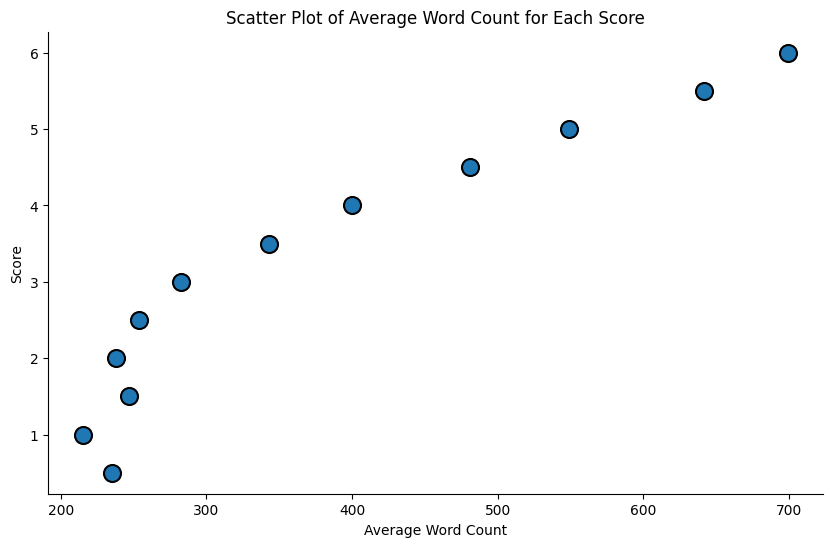

In [26]:
# Calculate average word count for each score
avg_word_count = train_essay_score.groupby('score')['word_count'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='word_count', y='score', data=avg_word_count, s=150, edgecolor='k', linewidth=1.5)

plt.title('Scatter Plot of Average Word Count for Each Score')
plt.xlabel('Average Word Count')
plt.ylabel('Score')

sns.despine()

plt.show()

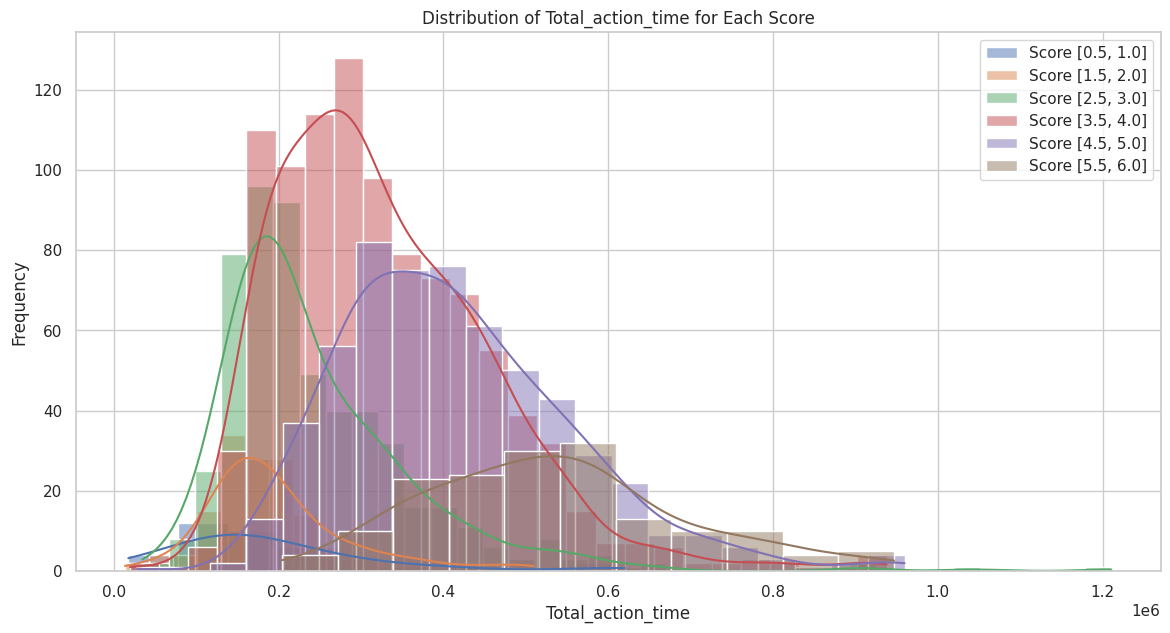

In [27]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

# Loop through unique scores and create a histogram for each
for idx in range(0,len(train_essay_score['score'].unique()),2):
    scores = sorted(train_essay_score['score'].unique())[idx:idx+2]
    sns.histplot(train_essay_score[train_essay_score['score'].isin(scores)]['Total_action_time'], label=f'Score {scores}', kde=True)

plt.title('Distribution of Total_action_time for Each Score')
plt.xlabel('Total_action_time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

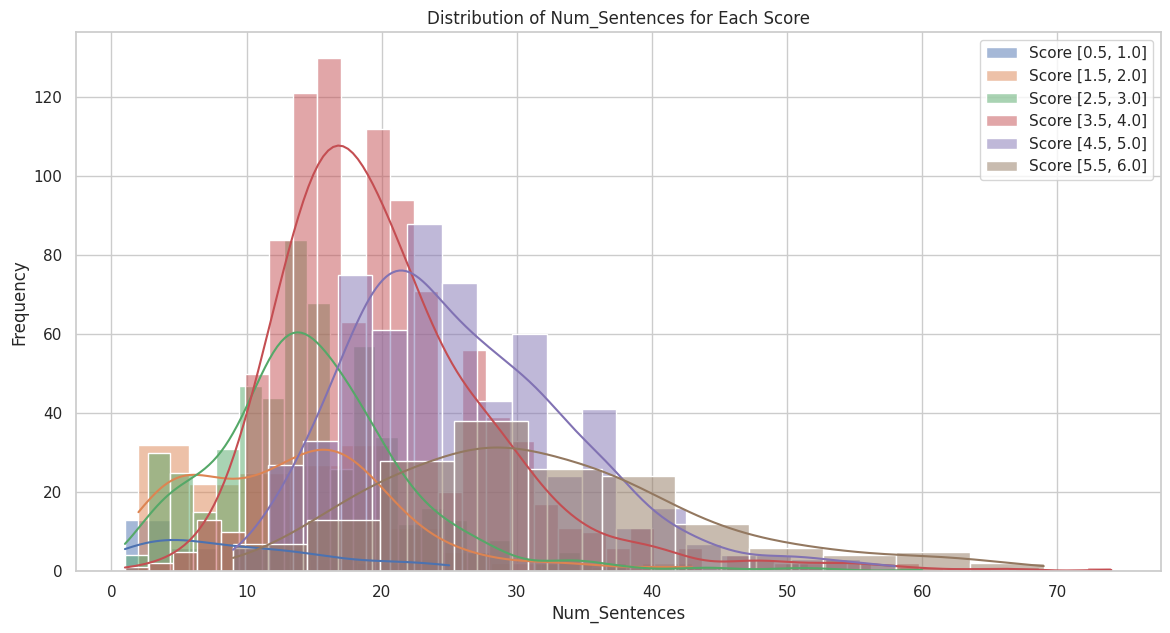

In [28]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

# Loop through unique scores and create a histogram for each
for idx in range(0,len(train_essay_score['score'].unique()),2):
    scores = sorted(train_essay_score['score'].unique())[idx:idx+2]
    sns.histplot(train_essay_score[train_essay_score['score'].isin(scores)]['Num_Sentences'], label=f'Score {scores}', kde=True)

plt.title('Distribution of Num_Sentences for Each Score')
plt.xlabel('Num_Sentences')
plt.ylabel('Frequency')
plt.legend()
plt.show()

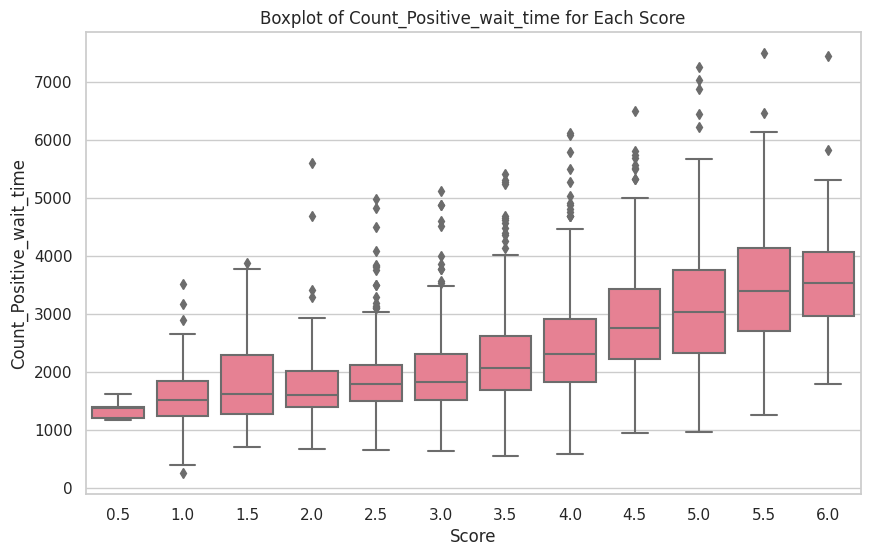

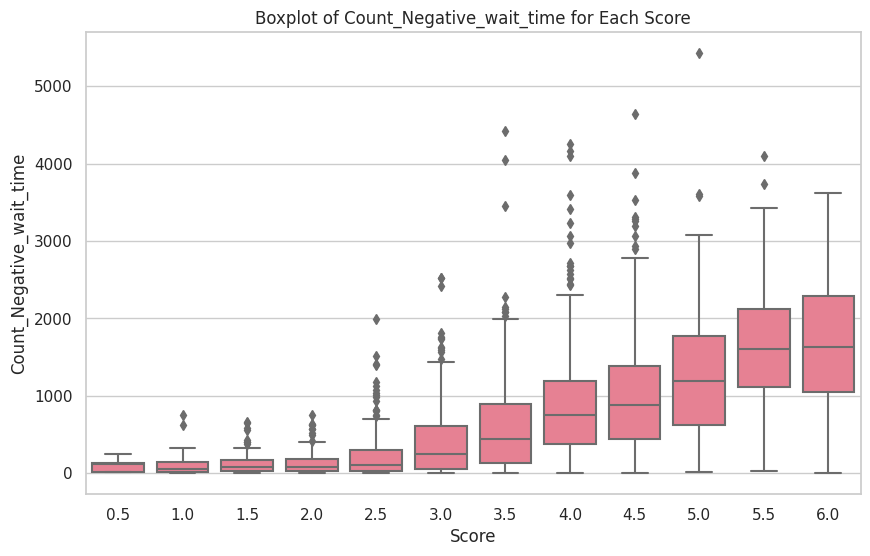

In [29]:
colors = sns.color_palette("husl", n_colors=1)

plt.figure(figsize=(10, 6))
sns.boxplot(x='score', y='Count_Positive_wait_time', data=train_essay_score, palette=colors)

plt.title('Boxplot of Count_Positive_wait_time for Each Score')
plt.xlabel('Score')
plt.ylabel('Count_Positive_wait_time')

plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='score', y='Count_Negative_wait_time', data=train_essay_score, palette=colors)

plt.title('Boxplot of Count_Negative_wait_time for Each Score')
plt.xlabel('Score')
plt.ylabel('Count_Negative_wait_time')

plt.show()


In [30]:
train_essay_score['score'].value_counts()

score
4.0    501
3.5    486
4.5    402
3.0    336
2.5    201
5.0    179
5.5    128
2.0     92
1.5     69
6.0     37
1.0     35
0.5      5
Name: count, dtype: int64

In [31]:
bins = [0, 2, 4, 6]
labels = ['0.5-2.0', '2.5-4.0', '4.5-6.0']

# Create a new column 'score_category' based on the specified bins
train_essay_score['3_score_category'] = pd.cut(train_essay_score['score'], bins=bins, labels=labels, include_lowest=True)

target = 'score'
train_essay_score_ordered = pd.concat([train_essay_score.drop(target,axis=1), train_essay_score[target]],axis=1)

In [32]:
train_essay_score_ordered.head()

id                                              essay  word_count  \
0  001519c8  qqqqqqqqq qq qqqqq qq qqqq qqqq.  qqqqqq qqq q...         256   
1  0022f953  qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq...         324   
2  0042269b  qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq ...         409   
3  0059420b  qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq qq...         207   
4  0075873a  qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq...         255   

   All Move From  Input  Nonproduction  Paste  Remove/Cut  Replace  \
0              3   2010            120      0         417        7   
1              0   1938            254      1         260        1   
2              0   3515            175      0         439        7   
3              0   1304             99      1         151        1   
4              0   1942             72      0         517        0   

   Total_Positive_wait_time  Total_Negative_wait_time  \
0                 1531192.0                  -30992.0   
1                 1502350.0                  -19395.0   
2                 1418539.0                  -72512.0   
3                 1183046.0                   -9568.0   
4                 1297666.0                  -27366.0   

   Count_Positive_wait_time  Count_Negative_wait_time  Total_action_time  \
0                      1655                       814             297243   
1                      1838                       542             275391   
2                      1948                      2025             421201   
3                      1350                       184             189596   
4                      1489                       729             313702   

   Num_Sentences  Num_Paragraphs 3_score_category  score  
0             14               3          2.5-4.0    3.5  
1             15               1          2.5-4.0    3.5  
2             19               6          4.5-6.0    6.0  
3             12               1          0.5-2.0    2.0  
4             16               5          2.5-4.0    4.0

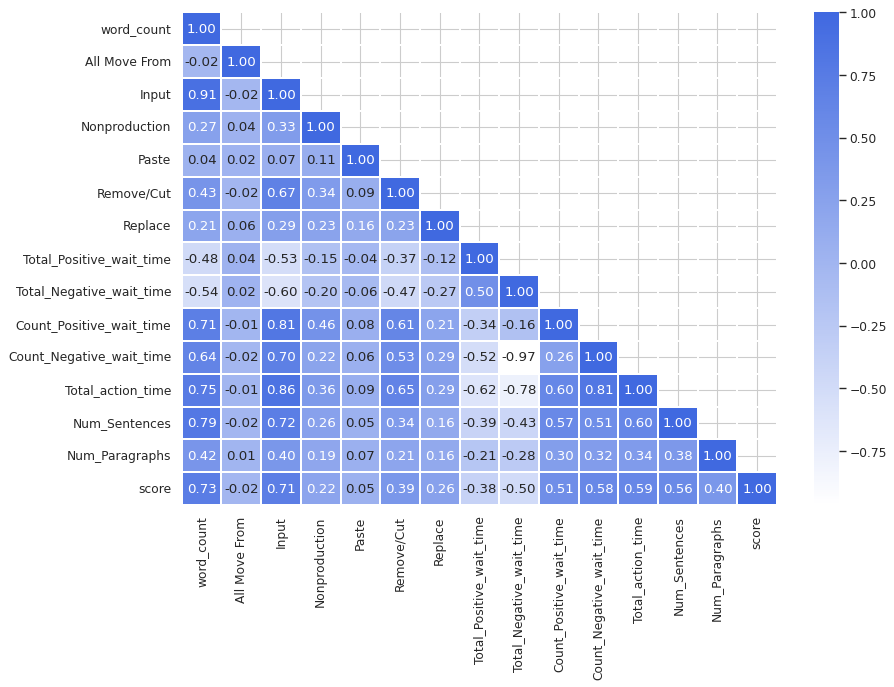

In [33]:
# Define a colormap
royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
royalblue_r = royalblue.reversed()

numeric_columns = train_essay_score.select_dtypes(include=np.number).columns
train_essay_score_numeric = train_essay_score[numeric_columns]

train_essay_score_numeric_ordered = pd.concat([train_essay_score_numeric.drop(target,axis=1), train_essay_score_numeric[target]],axis=1)

corr = train_essay_score_numeric_ordered.corr(method='spearman')

# Create a mask so that we see the correlation values only once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)] = True

# Plot the heatmap correlation
plt.figure(figsize=(12,8), dpi=80)
sns.heatmap(corr, mask=mask, annot=True, cmap=royalblue, fmt='.2f', linewidths=0.2)
plt.show()

In [34]:
train_essay_score_numeric_ordered.head()

word_count  All Move From  Input  Nonproduction  Paste  Remove/Cut  \
0         256              3   2010            120      0         417   
1         324              0   1938            254      1         260   
2         409              0   3515            175      0         439   
3         207              0   1304             99      1         151   
4         255              0   1942             72      0         517   

   Replace  Total_Positive_wait_time  Total_Negative_wait_time  \
0        7                 1531192.0                  -30992.0   
1        1                 1502350.0                  -19395.0   
2        7                 1418539.0                  -72512.0   
3        1                 1183046.0                   -9568.0   
4        0                 1297666.0                  -27366.0   

   Count_Positive_wait_time  Count_Negative_wait_time  Total_action_time  \
0                      1655                       814             297243   
1                      1838                       542             275391   
2                      1948                      2025             421201   
3                      1350                       184             189596   
4                      1489                       729             313702   

   Num_Sentences  Num_Paragraphs  score  
0             14               3    3.5  
1             15               1    3.5  
2             19               6    6.0  
3             12               1    2.0  
4             16               5    4.0

In [35]:
train_essay_score_ordered.select_dtypes(include=np.number).columns.tolist()

['word_count',
 'All Move From',
 'Input',
 'Nonproduction',
 'Paste',
 'Remove/Cut',
 'Replace',
 'Total_Positive_wait_time',
 'Total_Negative_wait_time',
 'Count_Positive_wait_time',
 'Count_Negative_wait_time',
 'Total_action_time',
 'Num_Sentences',
 'Num_Paragraphs',
 'score']

In [36]:
sns.set_palette(['royalblue', 'darkturquoise', 'limegreen'])

Num_Features = train_essay_score_ordered.select_dtypes(include=np.number).columns.tolist()
Num_Features.remove('score')

fig, ax = plt.subplots(len(Num_Features), 2, figsize=(30,75), dpi=200, gridspec_kw={'width_ratios': [1, 2]})
Target = '3_score_category'


for i,col in enumerate(Num_Features):
    # barplot
    graph = sns.barplot(data=train_essay_score_ordered, x=Target, y=col, ax=ax[i,0])
    # kde Plot
    sns.kdeplot(data=train_essay_score_ordered[train_essay_score_ordered[Target]=='0.5-2.0'], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0.5-2.0')
    sns.kdeplot(data=train_essay_score_ordered[train_essay_score_ordered[Target]=='2.5-4.0'], x=col, fill=True, linewidth=2, ax=ax[i,1], label='2.5-4.0')
    sns.kdeplot(data=train_essay_score_ordered[train_essay_score_ordered[Target]=='4.5-6.0'], x=col, fill=True, linewidth=2, ax=ax[i,1], label='4.5-6.0')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='3_score_category', loc='upper right')
    # Add bar sizes to our plot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')

plt.suptitle('Numerical Features vs Target Distribution', fontsize=22)
plt.tight_layout()
plt.show()

In [37]:
import math

def round_to_nearest_half(value):
    return np.round(value * 2) / 2

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, classification_report

Target = 'score'
X = train_essay_score_numeric_ordered.drop(Target, axis=1)
y = train_essay_score_numeric_ordered[Target]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=141, stratify=y)
X_test, y_test = X_temp, y_temp

In [39]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define a weighted loss function
def weighted_loss(y_true, y_pred, weight_factor=0.5):
    # Calculate the squared error
    squared_error = tf.square(y_true - y_pred)
    
    # Define weight factors based on the range of true values
    weight_factors = tf.where(
        (y_true >= 0.0) & (y_true <= 1.5),  # Adjust this range based on your data
        2.0,  # Lower weight for the specified range
        tf.where(
            (y_true >= 3.0) & (y_true <= 4.5),  # Adjust this range based on your data
            weight_factor,
            tf.where(
                (y_true >= 5.0) & (y_true <= 6.0),  # Adjust this range based on your data
                2.0,  # Lower weight for the specified range
                1.0  # Default weight for other ranges
            )
        )
    )
    
    # Apply weights to the error based on the target value
    weighted_error = weight_factors * squared_error
    
    # Calculate the mean loss
    return tf.reduce_mean(weighted_error)

# Define the model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(128, activation='relu')) 
model.add(Dense(64, activation='relu')) 
model.add(Dense(32, activation='relu')) 
model.add(Dense(1, activation='linear'))

# Compile the model with the weighted loss function
model.compile(optimizer=Adam(), loss=weighted_loss)

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
predictions = model.predict(X_test)

# Print some predictions
for true_value, pred_value in zip(y_test[:5], predictions[:5]):
    print(f'True Value: {true_value:.2f}, Predicted Value: {pred_value[0]:.2f}')


Epoch 1/50
62/62 [==============================] - 2s 9ms/step - loss: 4.6838 - val_loss: 2.6290
Epoch 2/50
62/62 [==============================] - 0s 5ms/step - loss: 1.6693 - val_loss: 1.4022
Epoch 3/50
62/62 [==============================] - 0s 5ms/step - loss: 0.9859 - val_loss: 0.9691
Epoch 4/50
62/62 [==============================] - 0s 5ms/step - loss: 0.7139 - val_loss: 0.7454
Epoch 5/50
62/62 [==============================] - 0s 5ms/step - loss: 0.5607 - val_loss: 0.6731
Epoch 6/50
62/62 [==============================] - 0s 5ms/step - loss: 0.5130 - val_loss: 0.6526
Epoch 7/50
62/62 [==============================] - 0s 5ms/step - loss: 0.4907 - val_loss: 0.5801
Epoch 8/50
62/62 [==============================] - 0s 5ms/step - loss: 0.4526 - val_loss: 0.5894
Epoch 9/50
62/62 [==============================] - 0s 5ms/step - loss: 0.4400 - val_loss: 0.5885
Epoch 10/50
62/62 [==============================] - 0s 5ms/step - loss: 0.4675 - val_loss: 0.5714
Epoch 11/50
62/62 [

In [40]:
for true_value, pred_value in zip(y_test[:5], predictions[:5]):
    print(f'True Value: {true_value:.2f}, Predicted Value: {pred_value[0]:.2f}')

True Value: 3.50, Predicted Value: 3.99
True Value: 3.50, Predicted Value: 4.14
True Value: 4.00, Predicted Value: 4.23
True Value: 4.00, Predicted Value: 4.14
True Value: 2.50, Predicted Value: 2.96


In [41]:
predictions_rounded_values = [round_to_nearest_half(value) for value in predictions]

for true_value, pred_value in zip(y_test[:10], predictions_rounded_values[:10]):
    print(f'True Value: {true_value:.2f}, Predicted Value: {pred_value[0]}')

True Value: 3.50, Predicted Value: 4.0
True Value: 3.50, Predicted Value: 4.0
True Value: 4.00, Predicted Value: 4.0
True Value: 4.00, Predicted Value: 4.0
True Value: 2.50, Predicted Value: 3.0
True Value: 3.00, Predicted Value: 4.5
True Value: 4.00, Predicted Value: 3.5
True Value: 5.50, Predicted Value: 4.0
True Value: 2.00, Predicted Value: 4.5
True Value: 3.50, Predicted Value: 4.5


In [42]:
def feature_extraction(df):
    df['wait_time'] = df['down_time'] - df.groupby('id')['up_time'].shift()
    df['wait_time'].fillna(0, inplace=True)
    
    wait_time_df = df.groupby('id')['wait_time'].agg(
    Total_Positive_wait_time=lambda x: x[x > 0].sum(),
    Total_Negative_wait_time=lambda x: x[x < 0].sum(),
    Count_Positive_wait_time=lambda x: (x > 0).sum(),
    Count_Negative_wait_time=lambda x: (x < 0).sum()
    ).reset_index()
    
    action_time_df = df.groupby('id')['action_time'].agg(
    Total_action_time=lambda x: x[x > 0].sum()
    ).reset_index()
    
    df['Updated_activity'] = df['activity'].apply(update_action)
    
    action_counts = df.groupby('id')['Updated_activity'].value_counts().unstack(fill_value=0)


    essayConstructor=EssayConstructor()
    essay=essayConstructor.getEssays(df)
    
    essay['word_count'] = essay['essay'].apply(lambda x: count_words(x))
    
    essay = pd.merge(essay, wait_time_df, on='id', how='left')
    essay = pd.merge(essay, action_time_df, on='id', how='left')
    essay = pd.merge(essay, action_counts, on='id', how='left')       

    essay['Num_Sentences'] = essay['essay'].apply(count_sentences)
    essay['Num_Paragraphs'] = essay['essay'].apply(count_paragraphs)
    
    essay_id = essay[['id']]
    
    required_columns = ['word_count', 'All Move From', 'Input', 'Nonproduction', 'Paste',
       'Remove/Cut', 'Replace', 'Total_Positive_wait_time',
       'Total_Negative_wait_time', 'Count_Positive_wait_time',
       'Count_Negative_wait_time', 'Total_action_time', 'Num_Sentences',
       'Num_Paragraphs']
    
    for col in required_columns:
        if col not in essay.columns:
            essay[col] = 0

    return essay_id, essay[required_columns]

In [43]:
processed_test_df_id, processed_test_df = feature_extraction(test_logs)

100%|██████████| 3/3 [00:00<00:00, 718.65it/s]


In [44]:
X_test = scaler.fit_transform(processed_test_df)
predictions = model.predict(X_test)
predictions

1/1 [==============================] - 0s 30ms/step


array([[1.8006953],
       [4.4133205],
       [3.981879 ]], dtype=float32)

In [45]:
predictions_rounded_values = [round_to_nearest_half(value[0]) for value in predictions]

In [46]:
processed_test_df_id['score'] = predictions_rounded_values

In [47]:
processed_test_df_id.to_csv("submission.csv", index=False)

In [48]:
processed_test_df_id

id  score
0  0000aaaa    2.0
1  2222bbbb    4.5
2  4444cccc    4.0